In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
import cv2
import os
import pandas as pd
import numpy as np
import random

_PICK_BATCH_SIZE = 500
_CLASSIFICATION_SIZE = 7

def one_hot_encode(x,size=_CLASSIFICATION_SIZE):
    ohe = np.zeros(size)
    ohe[x]=1
    return ohe

_TRAINING_DATA_DIR = 'drive/MyDrive/A2_Data/T2_Data/HAM10000_images_part_1/'
_TEST_DATA_DIR = 'drive/MyDrive/A2_Data/T2_Data//HAM10000_images_part_2/'
images_list_all = []
for filename in os.listdir(_TRAINING_DATA_DIR):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
       images_list_all.append(filename)
    else:
        print(f'Unable to read image: {filename}')
print(f'Total images in the training set: {len(images_list_all)}')

Total images in the training set: 5000


In [3]:
def get_images_from_dir(path,file_names):
    train_images_list = []
    train_images_list_names = []
    for filename in file_names:
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
            # Read the image using OpenCV
            image = cv2.imread(os.path.join(path, filename))
            # Append the image to the list and its name too
            if image is not None:
                train_images_list.append(image)
                train_images_list_names.append(filename)
            else:
                print(f'Unable to read image: {filename}')
    print(f'Total images in the training set: {len(train_images_list)}')
    return train_images_list,train_images_list_names
def get_images_meta(path = 'drive/MyDrive/A2_Data/T2_Data/HAM10000_metadata.csv'):
    meta  = pd.read_csv(path)
    meta = meta.sort_values(by = 'image_id',ascending=True)
    unique_values = meta['dx'].unique()
    value_to_int = {value: idx for idx, value in enumerate(unique_values)}
    meta['dx'] = meta['dx'].replace(value_to_int)
    return meta


In [4]:
def get_training_and_validation_data(train_images_list,train_images_list_names,meta,div_percentage):
    #join every image with its label to create training_data
    X_train = []
    Y_train = []
    for i in range(len(train_images_list_names)):
        row = meta[meta['image_id']==(train_images_list_names[i].split('.')[0])]
        X_train.append(train_images_list[i])
        Y_train.append(one_hot_encode(int(meta[meta['image_id']==(train_images_list_names[i].split('.')[0])]['dx'])))

    X_val = []
    Y_val = []
    for i in range(len(X_train)):
        #add div_percentage of images to validation set
        if(i>=len(X_train)):
            break
        if(random.randint(0,100)<=div_percentage):
            X_val.append(X_train[i])
            Y_val.append(Y_train[i])
            X_train.pop(i)
            Y_train.pop(i)
    print("train/val split = ",len(X_train),len(X_val))
    return X_train,Y_train,X_val,Y_val


# Logic to Train
Get all images_list_all in an array

init_model

till length(images_list_all)==0:

    pop _PICK_BATCH_SIZE number of images into from images_list_all

    put popped into get_images_from_dir()

        to get train_images_list,train_images_list_names

    get_training_and_validation_data(train_images_list,train_images_list_names,meta,div_percentage)

        to get training x validation data
        
    do model.fit

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=14336)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


1.4

    model = Sequential([
      Conv2D(64, (2, 2), activation='relu', input_shape=_IMAGES_SHAPE),
      MaxPooling2D((3, 3)),
      Conv2D(256, (3, 3), activation='relu'),
      MaxPooling2D((7, 7)),
      Conv2D(1024, (7, 7), activation='relu'),
      MaxPooling2D((9, 9)),
      Flatten(),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(7, activation='softmax')
    ])

  accuracy = 0.719

  1.5

    model = Sequential([
      Conv2D(32, (2, 2), activation='relu', input_shape=_IMAGES_SHAPE),
      MaxPooling2D((2, 2)),
      Conv2D(64, (5, 5), activation='relu'),
      MaxPooling2D((7, 7)),
      Conv2D(128, (7, 7), activation='relu'),
      MaxPooling2D((9, 9)),
      Flatten(),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(7, activation='softmax')
    ])

  accuracy = 0.75

  1.6

    model = Sequential([
      Conv2D(16, (2, 2), activation='relu', input_shape=_IMAGES_SHAPE),
      MaxPooling2D((2, 2)),
      Conv2D(32, (5, 5), activation='relu'),
      MaxPooling2D((7, 7)),
      Conv2D(64, (7, 7), activation='relu'),
      MaxPooling2D((9, 9)),
      Flatten(),
      Dense(256, activation='relu'),
      Dropout(0.5),
      Dense(7, activation='softmax')
    ])

  accuracy = 0.77

  1.7

    model = Sequential([
      Conv2D(4, (2, 2), activation='relu', input_shape=_IMAGES_SHAPE),
      MaxPooling2D((2, 2)),
      Conv2D(16, (5, 5), activation='relu'),
      MaxPooling2D((7, 7)),
      Conv2D(32, (7, 7), activation='relu'),
      MaxPooling2D((9, 9)),
      Flatten(),
      Dense(256, activation='relu'),
      Dropout(0.6),
      Dense(7, activation='softmax')
    ])
  accuracy = 0.8097

In [40]:
history = []
meta = get_images_meta()
model = None
with tf.device('/device:GPU:0'):

  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

  _IMAGES_SHAPE = (450, 600, 3)
  epochs = 5
  batch_size = 10
  model = Sequential([
      Conv2D(4, (2, 2), activation='relu', input_shape=_IMAGES_SHAPE),
      MaxPooling2D((2, 2)),
      Conv2D(16, (5, 5), activation='relu'),
      MaxPooling2D((7, 7)),
      Conv2D(32, (7, 7), activation='relu'),
      MaxPooling2D((9, 9)),
      Flatten(),
      Dense(256, activation='relu'),
      Dropout(0.6),
      Dense(7, activation='softmax')
  ])
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  while(len(images_list_all)>0):
    print(len(images_list_all), " number of images left")
    curr_training_images = images_list_all[:_PICK_BATCH_SIZE]
    images_list_all = images_list_all[_PICK_BATCH_SIZE:]
    train_images_list,train_images_list_names = get_images_from_dir(_TRAINING_DATA_DIR,curr_training_images)
    X_train,Y_train,X_val,Y_val = get_training_and_validation_data(train_images_list,train_images_list_names,meta,10)
    history_local = model.fit(np.array(X_train), np.array(Y_train), epochs=epochs, batch_size=batch_size, validation_data=(np.array(X_val), np.array(Y_val)))
    history.append(history_local)

5000  number of images left
Total images in the training set: 500
train/val split =  453 47
Epoch 1/5
46/46 [==============================] - 5s 34ms/step - loss: 2.6167 - accuracy: 0.5960 - val_loss: 0.8296 - val_accuracy: 0.7447
Epoch 2/5
46/46 [==============================] - 1s 23ms/step - loss: 0.9809 - accuracy: 0.6821 - val_loss: 0.7577 - val_accuracy: 0.7660
Epoch 3/5
46/46 [==============================] - 1s 24ms/step - loss: 0.9381 - accuracy: 0.7020 - val_loss: 0.7050 - val_accuracy: 0.7660
Epoch 4/5
46/46 [==============================] - 1s 23ms/step - loss: 0.8799 - accuracy: 0.7219 - val_loss: 0.7051 - val_accuracy: 0.8085
Epoch 5/5
46/46 [==============================] - 1s 22ms/step - loss: 0.8133 - accuracy: 0.7174 - val_loss: 0.6924 - val_accuracy: 0.7872
4500  number of images left
Total images in the training set: 500
train/val split =  450 50
Epoch 1/5
45/45 [==============================] - 1s 25ms/step - loss: 1.0098 - accuracy: 0.6600 - val_loss: 1.0820

In [41]:
# Import the necessary library
from tensorflow.keras.models import save_model

# Define the file path where you want to save the model
model_path = 'seven_types_cancer_classifier_update_1.7.h5'

# Save the model to the specified file path
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to seven_types_cancer_classifier_update_1.7.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
model_v = '1.7'
save_history = '['
for i in history:
  save_history += str(i.history)
  save_history +=','
save_history += ']'
print(save_history)
file_path = model_v+'_history.txt'
with open(file_path, 'w') as file:
    file.write(save_history)

[{'loss': [2.61665940284729, 0.9808990955352783, 0.9381027817726135, 0.8799293637275696, 0.8133474588394165], 'accuracy': [0.5960264801979065, 0.6821191906929016, 0.7019867300987244, 0.7218543291091919, 0.7174392938613892], 'val_loss': [0.8296385407447815, 0.7577307820320129, 0.7049545645713806, 0.705101728439331, 0.6923584342002869], 'val_accuracy': [0.7446808218955994, 0.7659574747085571, 0.7659574747085571, 0.8085106611251831, 0.7872340679168701]},{'loss': [1.0097839832305908, 0.9014658331871033, 0.853091835975647, 0.7703078389167786, 0.7514656782150269], 'accuracy': [0.6600000262260437, 0.6866666674613953, 0.6977777481079102, 0.7311111092567444, 0.7377777695655823], 'val_loss': [1.0820107460021973, 1.0296125411987305, 1.1315324306488037, 1.003844141960144, 1.1903488636016846], 'val_accuracy': [0.6000000238418579, 0.6000000238418579, 0.5600000023841858, 0.5799999833106995, 0.6000000238418579]},{'loss': [0.9603658318519592, 0.8842225670814514, 0.786770224571228, 0.8384944796562195, 0

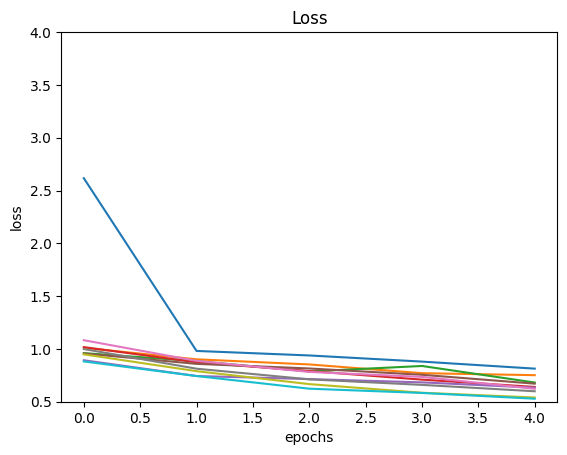

<Figure size 640x480 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt

#plotting losses
_SKIPPING = 0
skip = _SKIPPING
for history_instance in history:
    if(skip==0):
        plt.plot(history_instance.history['loss'])
        skip=_SKIPPING
    else:
        skip-=1

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.ylim(0.5,4)
# Display the plot
plt.show()
plt.savefig(model_v+'_loss.png')

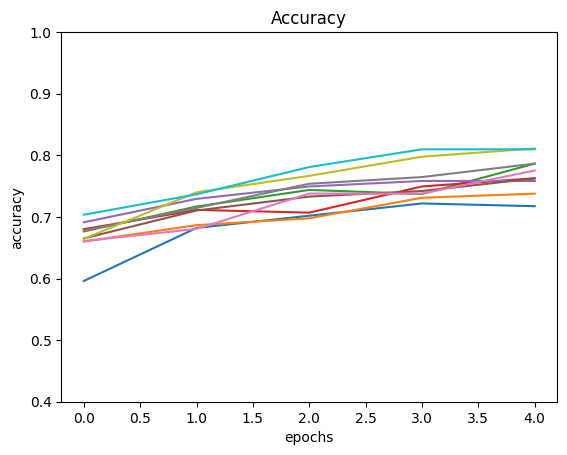

<Figure size 640x480 with 0 Axes>

In [44]:
_SKIPPING = 0
skip = _SKIPPING
for history_instance in history:
    if(skip==0):
        plt.plot(history_instance.history['accuracy'])
        skip=_SKIPPING
    else:
        skip-=1

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.ylim(0.4,1)
# Display the plot
plt.show()
plt.savefig(model_v+'_accuracy.png')

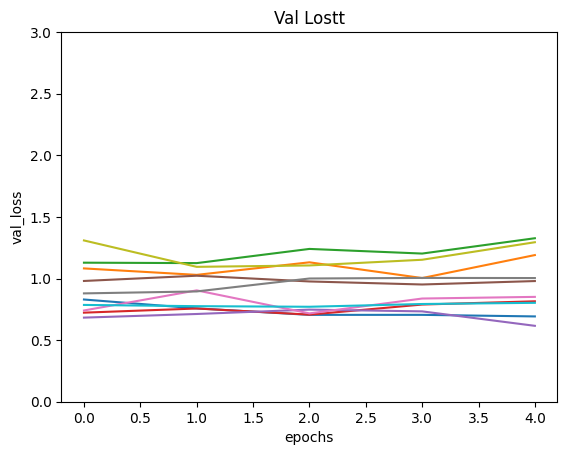

<Figure size 640x480 with 0 Axes>

In [45]:
_SKIPPING = 0
skip = _SKIPPING
for history_instance in history:
    if(skip==0):
        plt.plot(history_instance.history['val_loss'])
        skip=_SKIPPING
    else:
        skip-=1

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.title('Val Lostt')
plt.ylim(0,3)
# Display the plot
plt.show()
plt.savefig(model_v+'_val_loss.png')

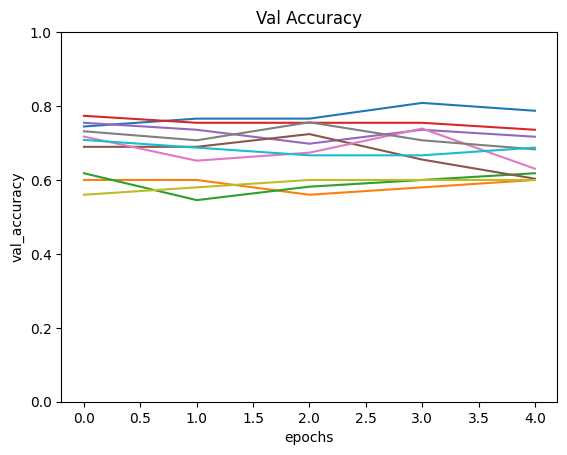

<Figure size 640x480 with 0 Axes>

In [46]:
_SKIPPING = 0
skip = _SKIPPING
for history_instance in history:
    if(skip==0):
        plt.plot(history_instance.history['val_accuracy'])
        skip=_SKIPPING
    else:
        skip-=1

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
plt.title('Val Accuracy')
plt.ylim(0,1)
# Display the plot
plt.show()
plt.savefig(model_v+'_val_accuracy.png')